In [1]:
import imp
from operator import imod
import click
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from os import mkdir, getcwd, path
import nilearn
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.image import mean_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_contrast_matrix
import nibabel as nib
from nilearn import plotting
import argparse
from nilearn.maskers import NiftiSpheresMasker

/var/folders/m4/9tqx2h0977b4g9l7n72kv3280000gn/T/ipykernel_27473/2328004926.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/xinyi/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [9]:
outfile = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise'
regressors = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/physio/regressors.csv'
t_scan = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/physio/mri_pulse.csv'

with open(t_scan) as file_name:
    frame_times = np.loadtxt(file_name)

# write directory
if not os.path.exists(outfile):
    mkdir(outfile)

outDir = outfile + "/analysis"
if not os.path.exists(outDir):
    mkdir(outDir)

print('Computation will be performed in directory: %s' %outDir)

# Define the calculated regressors
reg = pd.read_csv(regressors)
add_reg_names = []

index = len(reg.columns)
for i in range(index):
    add_reg_names.append('L%s'%i)

# input the time of scanning
with open(t_scan) as file_name:
    frame_times = np.loadtxt(file_name)
frame_times = frame_times[1:]


Computation will be performed in directory: /Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/analysis


In [10]:
frame_times

array([ 187818.,  204818.,  221818.,  238818.,  255818.,  272818.,
        289818.,  306818.,  323818.,  340818.,  357818.,  374818.,
        391818.,  408818.,  425818.,  442818.,  459819.,  476819.,
        493819.,  510819.,  527819.,  544819.,  561819.,  578819.,
        595819.,  612819.,  629819.,  646819.,  663819.,  680819.,
        697819.,  714819.,  731820.,  748820.,  765820.,  782820.,
        799820.,  816820.,  833820.,  850820.,  867820.,  884820.,
        901820.,  918820.,  935820.,  952820.,  969820.,  986820.,
       1003820., 1020820., 1037820., 1054821., 1071821., 1088821.,
       1105821., 1122821., 1139821., 1156821., 1173821., 1190821.,
       1207821., 1224821., 1241821., 1258821., 1275821., 1292821.,
       1309821., 1326822., 1343822., 1360822., 1377822., 1394822.,
       1411822., 1428822., 1445822., 1462822., 1479822., 1496822.,
       1513822., 1530822., 1547822., 1564822., 1581822., 1598822.,
       1615823., 1632823., 1649823., 1666823., 1683823., 17008

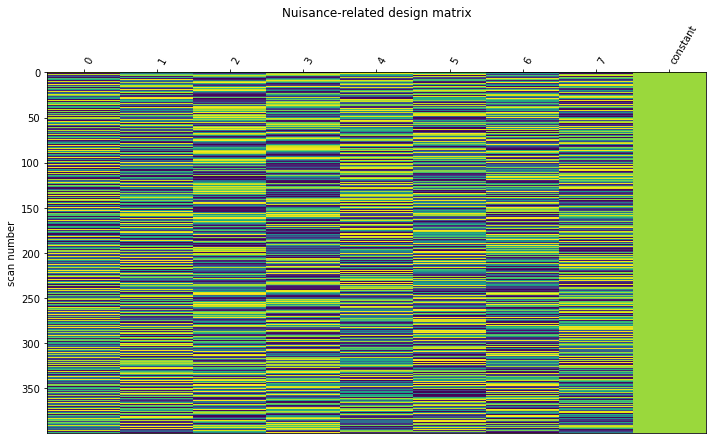

In [11]:

# Define the empty tasks conditions
conditions = []
duration = []
onsets = []

events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                    'duration': duration})


# Design the 1st level analysis
hrf_model = 'glover'
X1 = make_first_level_design_matrix(
    frame_times, events, drift_model=None,
    add_regs=reg, add_reg_names=add_reg_names, hrf_model=hrf_model)


fig, (ax1) = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
plot_design_matrix(X1, ax=ax1)
ax1.set_title('Nuisance-related design matrix', fontsize=12)
fig.savefig(outDir + '/design_matrix.png')


In [12]:
infile = '/Users/xinyi/Documents/GitHub/fMRI-PhysioNoise/test/0.0/prep/motion/_realign0/sub01_mcf.nii.gz'

# Build the 1st level model
fmri_glm = FirstLevelModel(
                        minimize_memory=False)
# Get the number of components and constant(residual)
n_columns = X1.shape[1]
mean = mean_img(infile)

# Build contrasts for each noise component
contrasts = np.zeros([index,index+1])
for i in range(index):
    contrasts[i,i] = 1

ax2 = plot_contrast_matrix(contrasts, design_matrix=X1)
ax2.figure.savefig(outDir + '/contrasts.png')

# Fit with GLM model
fmri_glm = fmri_glm.fit(infile, design_matrices=X1)

# Save the nii image of statistical value of each noise component
for i in range(index):
    z_img = fmri_glm.compute_contrast(contrasts[i], 
                        output_type='z_score')
    nib.save(z_img, os.path.join(outDir,"zstat_%s.nii.gz"%i))
    # Plot the contrasts
    plotting.plot_stat_map(
        z_img,
        bg_img=mean, threshold=3, 
        title="zsta_component_%s"%i,
        output_file = os.path.join(outDir,"zstat_cont_%s.png"%i))
# Save the residual data for the further use
